Here we create the database from files and prepare it for neural net

<h1> General Settings </h>

In [1]:
# Imports
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time

import utils

In [3]:
# Settings

all_names = [
    'ADGU101504',
    'ALUR012904',
    'BECA011405',
    'BRCA062405',
    'BRLO041102',
    'BTOL083105',
    'BTOL090105',
    'CAPO092605',
    'CRCA020205',
    'ESCI031905',
    'TAGO061203']

path_rec = "ssdata/register/"
rec_postamble = ".rec"

path_marks = "ssdata/label/marks/"
marks_preamble = "FixedSS_"
marks_postamble = ".txt"

path_states = "ssdata/label/states/"
states_preamble = "StagesOnly_"
states_postamble = ".txt"

params = {
    'channel': 1,           # Channel to be used
    'dur_epoch': 30,        # Time of window page [s]
    'n2_val': 3,            # N2 state coding value
    'context': 5,           # Context to be added before and after an epoch, in [s]
    'context_add': 1        # Additional context so we can keep the original after FFT, in [s]
    # 'dur_min_ss': 0.3,      # Min SS duration [s]
    # 'dur_max_ss': 3.0       # Max SS duration [s]
}

<h1> Read Files </h>

In [4]:
# Read everything
signal_list = []
marks_list = []
states_list = []
for i in range(len(all_names)):
    # Read EEG Signal
    path_edf_file = path_rec + all_names[i] + rec_postamble
    signal, fs = utils.dataload.read_eeg(path_edf_file, params['channel'])
    signal_list.append(signal)
    # Read Expert marks
    path_marks_file = path_marks + marks_preamble + all_names[i] + marks_postamble
    marks = utils.dataload.read_marks(path_marks_file, params['channel'])
    marks_list.append(marks)
    # Read states
    path_states_file = path_states + states_preamble + all_names[i] + states_postamble
    states = utils.dataload.read_states(path_states_file)
    states_list.append(states)    
params['fs'] = fs           # Save sampling frequency [Hz]

print(len(signal_list), ' EEG signals have been read.')
print(len(marks_list), ' sleep spindle marks files have been read.')
print(len(states_list), ' state annotations files have been read.')
print('Sampling Frequency: ', fs, 'Hz')

11  EEG signals have been read.
11  sleep spindle marks files have been read.
11  state annotations files have been read.
Sampling Frequency:  200 Hz


In [ ]:
# Show complete EEG
ind = 10

# Show plot of signal
n_total = signal_list[ind].shape[0]
time_axis = np.arange(0, n_total, 1) / params['fs']
plt.figure(figsize=(12, 3))
plt.plot(time_axis, signal_list[ind], 'b')
plt.xlabel('Time [s]')
plt.ylabel('F4-C4 [uV]')
plt.title('EEG of register {0}'.format(ind+1))
plt.show()

In [ ]:
# Show states
ind = 0

n_total = states_list[ind].shape[0]
epoch_axis = np.arange(1, n_total+1, 1)
plt.figure(figsize=(12, 3))
plt.plot(epoch_axis, states_list[ind], 'b')
plt.xlabel('Epoch')
plt.ylabel('State')
plt.title('Hypnogram of register {0}'.format(ind+1))
plt.show()

In [ ]:
# Show marks

ind = 0
marks_ind = marks_list[ind]
print(marks_ind.shape, " Total marks")

# Let's show the first three marks
from_mark = 0
to_mark = 2
sample_start = marks_ind[from_mark, 0] - params['fs']
sample_end = marks_ind[to_mark, 1] + params['fs']
segment_eeg = signal_list[ind][sample_start:sample_end]
time_axis = np.arange(sample_start, sample_end, 1) / params['fs']
plt.figure(figsize=(15, 3))
plt.plot(time_axis, segment_eeg, 'b')
max_y = max(abs(segment_eeg))
for index in range(from_mark, to_mark+1):
    beg_x = [marks_ind[index, 0] / params['fs'], marks_ind[index, 0] / params['fs']]
    end_x = [marks_ind[index, 1] / params['fs'], marks_ind[index, 1] / params['fs']]
    plt.plot(beg_x, [-max_y, max_y], 'k')
    plt.plot(end_x, [-max_y, max_y], 'k')

plt.xlabel('Time [s]')
plt.ylabel('F4-C4 [uV]')
plt.title('EEG of register {0}'.format(ind+1))
plt.show()

<h1> Extract and Normalize N2 Epochs </h>

In [5]:
# Extraction of N2 epochs in data frame of Pandas
n2eeg_df = utils.transform.get_n2_epochs(signal_list, states_list, marks_list, params)

print(n2eeg_df.dtypes)
n2eeg_df.head()

ID_REG         int64
ID_SEG         int64
ID_EPOCH       int64
EEG_DATA      object
MARKS_DATA    object
dtype: object


,ID_REG,ID_SEG,ID_EPOCH,EEG_DATA,MARKS_DATA
0,0,0,28,"[17.412680247196153, 14.451819638361181, 10.08...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0,0,29,"[-0.2114900434882124, -1.057450217441062, -1.9...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0,0,30,"[-16.566720073243307, -23.898374914168002, -29...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0,0,31,"[19.80956740672923, 16.848706797894256, 13.746...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0,0,32,"[39.1256580453193, 40.39459830624857, 41.66353...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [6]:
# Clip normalization
n2eeg_df = utils.transform.clip_normalize(n2eeg_df, 99)

print(n2eeg_df.dtypes)    
n2eeg_df.head()


ID_REG         int64
ID_SEG         int64
ID_EPOCH       int64
EEG_DATA      object
MARKS_DATA    object
dtype: object


,ID_REG,ID_SEG,ID_EPOCH,EEG_DATA,MARKS_DATA
0,0,0,28,"[0.813055999656958, 0.6720143713307104, 0.4638...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0,0,29,"[-0.026477502284992058, -0.06677511037820566, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0,0,30,"[-0.8055645920871217, -1.1548105288949728, -1....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0,0,31,"[0.9272325559210632, 0.7861909275948157, 0.638...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0,0,32,"[1.8473612740494405, 1.9078076861892606, 1.968...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


[0.813056   0.67201437 0.46381006 ... 0.161578   0.12799666 0.10784786]
()


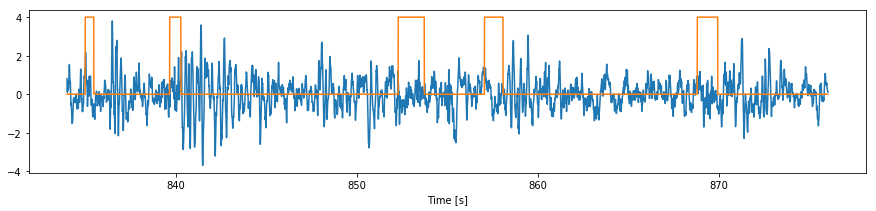

28


In [14]:
# Show a certain epoch to see the results

idx = 0
print(n2eeg_df.loc[idx, 'EEG_DATA'])
epoch = n2eeg_df.loc[idx, 'ID_EPOCH']
sample_start = (epoch * params['dur_epoch'] - params['context'] - params['context_add']) * params['fs']
sample_end = ((epoch + 1) * params['dur_epoch'] + params['context'] + params['context_add']) * params['fs']
time_axis = np.arange(sample_start, sample_end, 1) / params['fs']
plt.figure(figsize=(15, 3))
plt.plot(time_axis, n2eeg_df.loc[idx, 'EEG_DATA'])
plt.plot(time_axis, 4*n2eeg_df.loc[idx, 'MARKS_DATA'])
plt.xlabel('Time [s]')
plt.show()

print(n2eeg_df.loc[idx, 'ID_EPOCH'])

<h1> FFT from N2 </h>

[0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
200
8000 10
(8000, 10)
8400 0.005 10 (8000, 10)
105.26150943386848 0.0013217464071993547


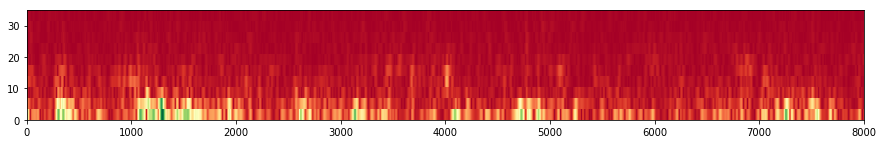

In [96]:
# Compute FFT of every N2 epoch
import matplotlib.cm as cm
# mini example of one epoch

idx = 0
win_size = 0.3 # [s]
step_size = 1
min_freq = 0.1 #[hz]
max_freq = 35 #[hz]

epoch_signal = n2eeg_df.loc[idx, 'EEG_DATA']
win_size = win_size*params['fs']
n_signal = epoch_signal.size
time_step = 1/params['fs']
win_half = int(np.floor(win_size/2))
n_segment = 2 * win_half + 1
freq = np.fft.fftfreq(n_segment, d=time_step)
freq = freq[0:int(n_segment/2)]
chosen = np.bitwise_and(min_freq <= freq, freq <= max_freq).astype(int)
print(chosen)
context_size = params['context_add'] * params['fs']
print(context_size)
print(n_signal - 2 * context_size, np.sum(chosen))
example_spec = np.zeros((n_signal - 2 * context_size, np.sum(chosen)))  # sample, freq
print(example_spec.shape)
for sample in np.arange(context_size, n_signal - context_size, step_size):
    segment = epoch_signal[(sample - win_half):(sample + win_half)]
    n_segment = segment.size
    # FFT with hamming window
    fourier = np.abs(np.fft.fft(segment * np.hamming(n_segment)))
    fourier = fourier[0:int(n_segment/2)]
    fourier[1:-2] = 2* fourier[1:-2]
    fourier = fourier[chosen == 1]
    example_spec[sample - context_size, :] = fourier    
print(n_signal, time_step, fourier.size, example_spec.shape)
plt.figure(figsize=(15, 3))
plt.imshow(np.transpose((example_spec)), extent=[0,8000,0,35], aspect=30, cmap=cm.RdYlGn, origin='lower')
print(np.max(example_spec), np.min(example_spec))

In [11]:
# Compute FFT for entire dataset

start = time.time()


win_size = 0.3 # [s]
step_size = 1 # in samples
min_freq = 0.1 #[hz]
max_freq = 35 #[hz]

win_size = win_size*params['fs']
time_step = 1/params['fs']
win_half = int(np.floor(win_size/2))
n_segment = 2 * win_half + 1
freq = np.fft.fftfreq(n_segment, d=time_step)
freq = freq[0:int(n_segment/2)]
chosen = np.bitwise_and(min_freq <= freq, freq <= max_freq).astype(int)
context_size = params['context_add'] * params['fs']

rows_list = []
for idx in range(10):
    epoch_signal = n2eeg_df.loc[idx, 'EEG_DATA']
    epoch_marks = n2eeg_df.loc[idx, 'MARKS_DATA']
    n_signal = epoch_signal.size
    for sample in np.arange(context_size, n_signal - context_size, step_size):
        segment = epoch_signal[(sample - win_half):(sample + win_half + 1)]
        # FFT with hamming window
        fourier = np.abs(np.fft.fft(segment * np.hamming(n_segment)))
        fourier = fourier[0:int(n_segment/2)]
        fourier[1:-2] = 2* fourier[1:-2]
        fourier = fourier[chosen == 1]
        # Save it
        dict_tmp = {}
        dict_tmp.update({'ID_REG': n2eeg_df.loc[idx, 'ID_REG']})
        dict_tmp.update({'ID_SEG': n2eeg_df.loc[idx, 'ID_SEG']})
        dict_tmp.update({'ID_EPOCH': n2eeg_df.loc[idx, 'ID_EPOCH']})
        dict_tmp.update({'FFT_DATA': fourier})
        dict_tmp.update({'MARK': epoch_marks[sample]})
        rows_list.append(dict_tmp)
n2fft_df = pd.DataFrame(rows_list)
n2fft_df = n2fft_df[['ID_REG', 'ID_SEG', 'ID_EPOCH', 'FFT_DATA', 'MARK']]

print('Ready')
end = time.time()
print(end - start)

print(n2fft_df.dtypes)    
n2fft_df.head()


Ready
4.68042254447937
ID_REG       int64
ID_SEG       int64
ID_EPOCH     int64
FFT_DATA    object
MARK         int64
dtype: object


,ID_REG,ID_SEG,ID_EPOCH,FFT_DATA,MARK
0,0,0,28,"[52.991359056421985, 17.744060346383918, 10.72...",0
1,0,0,28,"[53.26635366291548, 18.481030754414558, 10.780...",1
2,0,0,28,"[53.39462652452004, 19.19542383207785, 10.7583...",1
3,0,0,28,"[53.35740209067238, 19.88577254739931, 10.6341...",1
4,0,0,28,"[53.14583552036396, 20.54389078592557, 10.3902...",1


In [35]:
# Another try


start = time.time()

win_size = 0.3 # [s]
step_size = 1 # in samples
min_freq = 0.1 #[hz]
max_freq = 35 #[hz]

win_size = win_size*params['fs']
time_step = 1/params['fs']
win_half = int(np.floor(win_size/2))
n_segment = 2 * win_half + 1
freq = np.fft.fftfreq(n_segment, d=time_step)
freq = freq[0:int(n_segment/2)]
chosen = np.bitwise_and(min_freq <= freq, freq <= max_freq).astype(int)
context_size = params['context_add'] * params['fs']

# First we only split in segments
rows_list = []
for idx in range(n2eeg_df.shape[0]):
    if (idx+1)%50 == 0 and idx!=0:
        print(idx+1, '/', n2eeg_df.shape[0],' -- Time elapsed:', time.time() - start, ' s')
    epoch_signal = n2eeg_df.loc[idx, 'EEG_DATA']
    epoch_marks = n2eeg_df.loc[idx, 'MARKS_DATA']
    n_signal = epoch_signal.size
    for sample in np.arange(context_size, n_signal - context_size, step_size):
        segment = epoch_signal[(sample - win_half):(sample + win_half + 1)]
        # Save it
        dict_tmp = {}
        dict_tmp.update({'ID_REG': n2eeg_df.loc[idx, 'ID_REG']})
        dict_tmp.update({'ID_SEG': n2eeg_df.loc[idx, 'ID_SEG']})
        dict_tmp.update({'ID_EPOCH': n2eeg_df.loc[idx, 'ID_EPOCH']})
        dict_tmp.update({'FFT_DATA': segment})
        dict_tmp.update({'MARK': epoch_marks[sample]})
        rows_list.append(dict_tmp)
print('Splitting Ready, Total Time Elapsed: ', time.time() - start, ' s')
n2fft_df = pd.DataFrame(rows_list)
n2fft_df = n2fft_df[['ID_REG', 'ID_SEG', 'ID_EPOCH', 'FFT_DATA', 'MARK']]
# Now we apply fourier transform

def to_fourier(x):
    fourier = np.abs(np.fft.fft(x * np.hamming(x.size)))
    fourier = fourier[0:int(x.size/2)]
    fourier[1:-2] = 2* fourier[1:-2]
    fourier = fourier[chosen == 1]
    return fourier

n2fft_df.loc[:, 'FFT_DATA'] = n2fft_df.loc[:, 'FFT_DATA'].map(to_fourier)


print('FFT Ready, Total Time Elapsed: ', time.time() - start, ' s')

print(n2fft_df.dtypes)    
n2fft_df.head()

50 / 3923  -- Time elapsed: 7.170181512832642  s
Splitting Ready, Total Time Elapsed:  7.31354546546936  s
FFT Ready, Total Time Elapsed:  19.03256106376648  s
ID_REG       int64
ID_SEG       int64
ID_EPOCH     int64
FFT_DATA    object
MARK         int64
dtype: object


,ID_REG,ID_SEG,ID_EPOCH,FFT_DATA,MARK
0,0,0,28,"[52.991359056421985, 17.744060346383918, 10.72...",0
1,0,0,28,"[53.26635366291548, 18.481030754414558, 10.780...",1
2,0,0,28,"[53.39462652452004, 19.19542383207785, 10.7583...",1
3,0,0,28,"[53.35740209067238, 19.88577254739931, 10.6341...",1
4,0,0,28,"[53.14583552036396, 20.54389078592557, 10.3902...",1


In [27]:
# Testing saving and loading

#Saving
pd.to_pickle(n2eeg_df, "testing.pkl")

print('Saved')

#Loading
unpickled_df = pd.read_pickle("testing.pkl")
print('Loaded')
unpickled_df.head()

Saved


In [19]:
import pandas as pd
unpickled_df = pd.read_pickle("n2fft_dataframe_full.pkl")
print('Loaded')




Loaded


In [21]:
print(unpickled_df.shape)
unpickled_df.head()

#unpickled_df[ unpickled_df['ID_REG']==10][unpickled_df['ID_EPOCH']==1091].shape

(3138300, 5)


,ID_REG,ID_SEG,ID_EPOCH,FFT_DATA,MARK
0,0,0,28,"[52.991359056421985, 17.744060346383918, 10.72...",0
1,0,0,28,"[48.8039666064177, 22.562798255082985, 7.56761...",1
2,0,0,28,"[28.938943934883145, 19.808024500041654, 0.427...",1
3,0,0,28,"[5.06491656463988, 14.446145955680779, 5.21376...",1
4,0,0,28,"[17.06173910475162, 10.096023672168675, 3.8831...",1
